### Step 1: Imports

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import seaborn as sns

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # TODO get GPU

from src.utils.get_data import get_data_loader
from src.utils.get_data import import_data

### Step 2: Get Data

In [17]:
DATA_PATH = "../data"
fc, lc = import_data(DATA_PATH, segmentation_type='coarse', is_user_features=True,
                     return_type='pd')
fn, ln = import_data(DATA_PATH, segmentation_type='no', is_user_features=True,
                     return_type='pd')

### Step 2.1: Data Analysis

#### Class Imbalance: We observe quite the heavy imbalance, in favor of label 0

Original dataset shape Counter({0.0: 1229, 1.0: 430})
(1659, 72) (1659, 1)


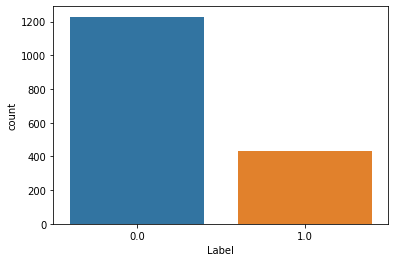

In [54]:
sns.countplot(x = 'Label', data=ln)
print('Original dataset shape %s' % Counter(ln["Label"]))
print(fn.shape, ln.shape)

Resampled dataset shape Counter({1.0: 1229, 0.0: 1229})


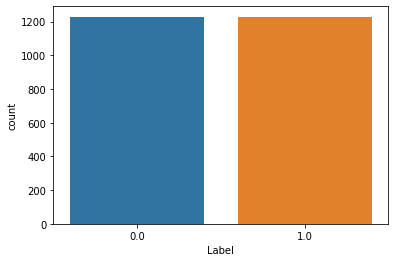

In [55]:
oversample = SMOTE(random_state=42)
fn_oversampled, ln_oversampled = oversample.fit_resample(fn, ln)

fn_oversampled = pd.DataFrame(fn_oversampled, columns=fn.columns)
ln_oversampled = pd.DataFrame(ln_oversampled, columns=ln.columns)

sns.countplot(x = 'Label', data=ln_oversampled)
print('Resampled dataset shape %s' % Counter(ln_oversampled["Label"]))

##### Split into Training and Test

In [56]:
X_train, X_test, y_train, y_test = train_test_split(fn, ln["Label"], test_size=0.33, random_state=420)

#### Standardize Inputs

In [57]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

### Step 3: Hyper Parameters

In [58]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_DIM = X_train.shape[1]
OUTPUT_DIM = 1
HIDDEN1_DIM = 100
HIDDEN2_DIM = 10
DROPOUT = 0.1
WEIGHT_DECAY = 1

### Step 4: Define Custom Data Loaders

In [59]:
## train data
"""
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
test_data = trainData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.values))
"""

'\nclass trainData(Dataset):\n    \n    def __init__(self, X_data, y_data):\n        self.X_data = X_data\n        self.y_data = y_data\n        \n    def __getitem__(self, index):\n        return self.X_data[index], self.y_data[index]\n        \n    def __len__ (self):\n        return len(self.X_data)\n\n## test data    \nclass testData(Dataset):\n    \n    def __init__(self, X_data):\n        self.X_data = X_data\n        \n    def __getitem__(self, index):\n        return self.X_data[index]\n        \n    def __len__ (self):\n        return len(self.X_data)\n    \n\ntrain_data = trainData(torch.FloatTensor(X_train), \n                       torch.FloatTensor(y_train))\ntest_data = trainData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.values))\n'

In [60]:
#train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = DataLoader(dataset=test_data, batch_size=1)

In [61]:
train_loader, test_loader = get_data_loader("no", smote=True, batch_size=64)

### Step 5: Define Custom NN

In [62]:
class BinaryClassification(nn.Module):
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim, dropout=0.1):
        super(BinaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, hidden1_dim) 
        self.layer_2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.layer_out = nn.Linear(hidden2_dim, output_dim) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.batchnorm1 = nn.BatchNorm1d(hidden1_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden2_dim)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [67]:
### Step 6: TODO

In [68]:
model = BinaryClassification(INPUT_DIM, OUTPUT_DIM, HIDDEN1_DIM, HIDDEN2_DIM, DROPOUT)
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

binaryClassification(
  (layer_1): Linear(in_features=72, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [69]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

from sklearn import metrics

def aoc(y_pred, y_test):
    y_pred = y_pred.detach().numpy()
    y_test = y_test.detach().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    return metrics.auc(fpr, tpr)

### Step X: Train the Model

In [70]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        #acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        acc = aoc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #print(acc1)

Epoch 001: | Loss: 0.66739 | Acc: 0.640
Epoch 002: | Loss: 0.62750 | Acc: 0.723
Epoch 003: | Loss: 0.58701 | Acc: 0.794
Epoch 004: | Loss: 0.55885 | Acc: 0.824
Epoch 005: | Loss: 0.55073 | Acc: 0.834
Epoch 006: | Loss: 0.55128 | Acc: 0.836
Epoch 007: | Loss: 0.55910 | Acc: 0.823
Epoch 008: | Loss: 0.55900 | Acc: 0.832
Epoch 009: | Loss: 0.56497 | Acc: 0.825
Epoch 010: | Loss: 0.56758 | Acc: 0.828
Epoch 011: | Loss: 0.57362 | Acc: 0.822
Epoch 012: | Loss: 0.57568 | Acc: 0.820
Epoch 013: | Loss: 0.57084 | Acc: 0.840
Epoch 014: | Loss: 0.58649 | Acc: 0.814
Epoch 015: | Loss: 0.57857 | Acc: 0.833
Epoch 016: | Loss: 0.58574 | Acc: 0.822
Epoch 017: | Loss: 0.59119 | Acc: 0.821
Epoch 018: | Loss: 0.58773 | Acc: 0.825
Epoch 019: | Loss: 0.58733 | Acc: 0.837
Epoch 020: | Loss: 0.58723 | Acc: 0.841
Epoch 021: | Loss: 0.58279 | Acc: 0.853
Epoch 022: | Loss: 0.58640 | Acc: 0.844
Epoch 023: | Loss: 0.59750 | Acc: 0.835
Epoch 024: | Loss: 0.60217 | Acc: 0.833
Epoch 025: | Loss: 0.60922 | Acc: 0.823


In [74]:
import matplotlib.pyplot as plt

plt.figure()
epoch_acc

21.79186986124579

<Figure size 432x288 with 0 Axes>

### Step X: Test the Model 

In [31]:
y_pred_list = []
y_test_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader: # todo for now i onyl include labels from data loader as _ THIS IS BAD! ITS WRONG!
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_test_list.append(y_batch.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test_list = [b.squeeze().tolist() for b in y_test_list]

In [37]:
len(y_test_list)

812

In [41]:
c = confusion_matrix(y_test_list, y_pred_list)

0.6785714285714286

In [38]:
print(classification_report(y_test_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.75      0.56      0.64       414
         1.0       0.64      0.80      0.71       398

    accuracy                           0.68       812
   macro avg       0.69      0.68      0.67       812
weighted avg       0.69      0.68      0.67       812



# TODO

first off, you wouldn't shuffle your test loader.

Here's an example:
 
batch_size = 20  
class_sample_count = [10, 1, 20, 3, 4] # dataset has 10 class-1 samples, 1 class-2 samples, etc.  
weights = 1 / torch.Tensor(class_sample_count)  
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)  
trainloader = data_utils.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, sampler = sampler) 

I THINK THIS OR SMOTE: BASICALLY THIS IS DEFAULT OVERSAMPLING
